General Imports

In [26]:
#intatll necessary libraries
%pip install numpy matplotlib scipy   
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
from scipy.stats import truncnorm


Note: you may need to restart the kernel to use updated packages.


# Problem 1

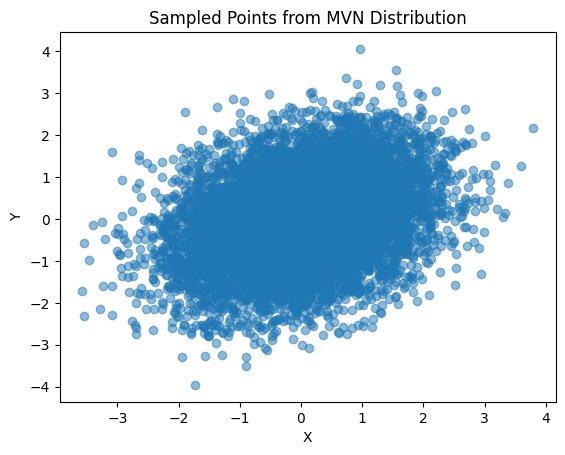

In [8]:
#1.a)
import numpy as np
"""
Goal:

Before writing a Gibbs sampler, let us really understand the motivation for such an
algorithm by using non-Gibbs methods first. Sample 10, 000 times from the joint distri-
bution specified above for ρ = 0.3 by using the function rMVN in R (or the corresponding
function in your language of choice).
"""

n = 10000
mu = [0, 0]
rho = 0.3 
cov = [[1, rho], [rho, 1]]

samples = np.random.multivariate_normal(mu, cov, n)

X_samples = samples[:, 0]
Y_samples = samples[:, 1]
plt.scatter(X_samples, Y_samples, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Sampled Points from MVN Distribution")
plt.show()


Sampled X values: [ 1.37140355 -1.44051508  0.11980774  0.17007838 -0.21161391]
Sampled Y values: [-0.34114517 -1.03967018 -1.24547349 -1.06205815 -0.41865362]


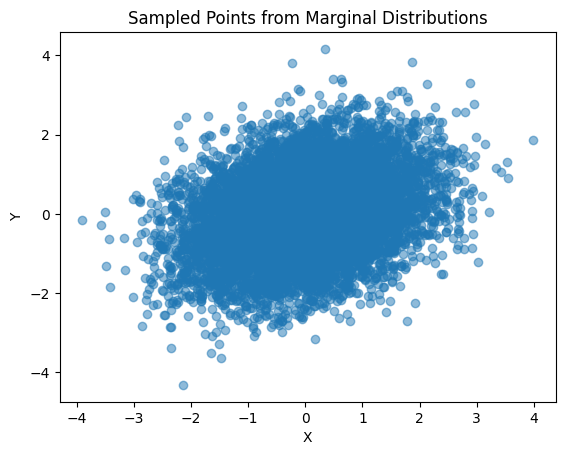

In [ ]:
# 1.b)
"""
Goal:

Write a function from scratch that takes in n, the number of samples we want from the
joint distribution, and rho, the correlation between X and Y . It should start out by
sampling from the marginal distribution of X and then use those samples to find the Y
values. (Sanity check that what your function returns for ρ = 0.3 matches your result
"""
def sample_marginal(n, rho):
    # Sample from  marginal distribution of X
    X = np.random.normal(0, 1, n)
    
    # Calculate the  Y values using the correlation
    Y = rho * X + np.sqrt(1 - rho**2) * np.random.normal(0, 1, n)
    
    return X, Y

# Example usage
n = 10000
rho = 0.3
X_samples, Y_samples = sample_marginal(n, rho)
print("Sampled X values:", X_samples[:5])
print("Sampled Y values:", Y_samples[:5])

plt.scatter(X_samples, Y_samples, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Sampled Points from Marginal Distributions")
plt.show()

# Plot 

# Gibbs Sampling Implementation

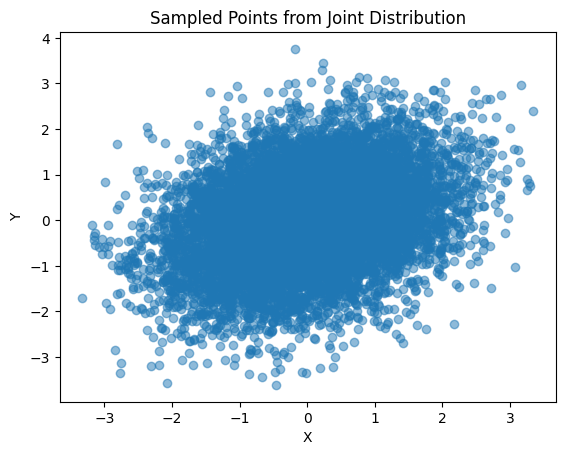

Gibbs sampling output:[[ 1.43510996  0.47970801]
 [ 0.19599482  1.11752395]
 [ 0.51583558 -0.81928502]
 [ 0.79139011  1.19592841]
 [ 0.67468277 -1.17111298]]
Estimated slope (should be close to rho): 0.30956876253341176


In [ ]:
#1.d)
"""
Goal:

Implement the Gibbs sampler (this should not take more than about a dozen lines of
code) and plot the observed joint density for 10, 000 samples and ρ = 0.3 against the
analytical joint density.
"""
# Gibbs Sampler Implementation
def gibbs_sampler(n, rho):
    samples = np.zeros((n, 2))
    x, y = 0.0, 0.0  # Initial state
    
    for i in range(n):
        # Sample X given Y
        x = np.random.normal(rho * y, np.sqrt(1 - rho**2))
        
        # Sample Y given X
        y = np.random.normal(rho * x, np.sqrt(1 - rho**2))
        
        samples[i] = [x, y]
    
    return samples

X_samples, Y_samples = gibbs_sampler(10000, 0.3).T
plt.scatter(X_samples, Y_samples, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gibbs sampling plot")
plt.show()

# Example usage
print("Gibbs sampling output" + str(gibbs_sampler(10000, 0.3)[:5]))

# print the trendline's slope as a check for the correlation
slope = np.cov(X_samples, Y_samples)[0, 1] / np.var(X_samples)
print("estimated slope (should be close to rho):", slope)

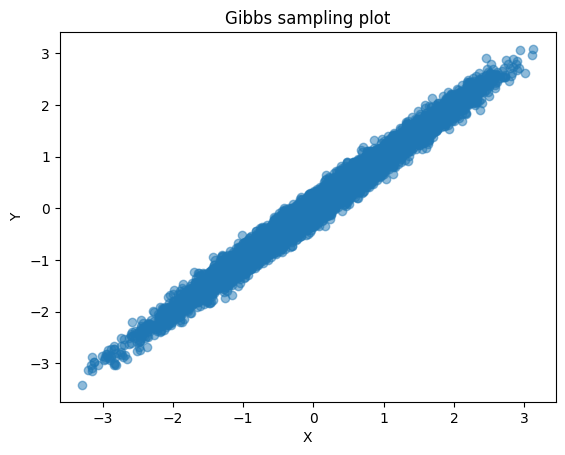

In [9]:
#1.e)
# testing the gibbs sampler with different values of rho
X_samples, Y_samples = gibbs_sampler(10000, 0.99).T
plt.scatter(X_samples, Y_samples, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gibbs sampling plot")
plt.show()

# Problem 2 

1.a Normalizing constant:

In [25]:

# calculate the normalizing constant for the bivariate normal distribution
# dist: f(x, y)= C*· e^{−100(x−y)^2}, |x| ≤ 10, |y| ≤ 10 (1)

# compute the integral over domain
def f(x,y):
    return np.exp(-100 * (x - y)**2)

integral, error = integrate.dblquad(f, -10, 10, lambda x: -10, lambda x: 10)
C = 1 / integral
print("Normalizing constant C:", C, "\nIntegral value:", integral)

Normalizing constant C: 0.2828928176781769 
Integral value: 3.5349077018194746


1.c Implement Met-Hastings

Rejection rate: 0.32135


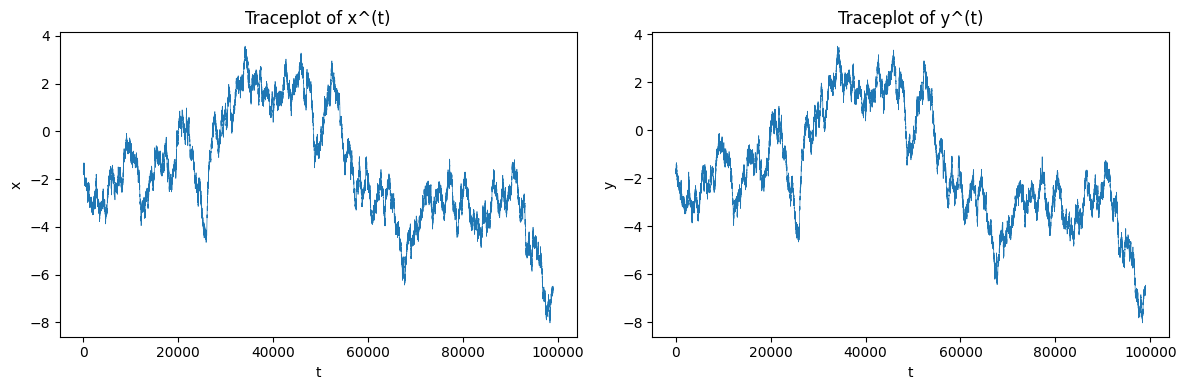

In [ ]:

# 1) Target density 
# The true target density is:
#   f(x, y) = C * exp(-100 (x - y)^2) for |x|<=10, |y|<=10
#   f(x, y) = 0 ow

def log_target(x, y):
    """
    Log of the unnormalized target density.
    Returns -inf outside the square [-10,10] x [-10,10].
    """
    if (x < -10) or (x > 10) or (y < -10) or (y > 10):
        return -np.inf
    return -100.0 * (x - y)**2  # log(exp(-100 (x-y)^2))

# 2) Metropolis–Hastings sampler

def metropolis_hastings(n_steps=100_000, burn_in=1000, sigma2=0.5, seed=0):
    """
    Random-walk MH with proposal:
        u' ~ N(u, sigma2 * I)
    where u = (x, y).
    Returns the full chain and the rejection rate.
    """
    rng = np.random.default_rng(seed)

    # stoing the samples
    samples = np.zeros((n_steps, 2))

    # startign values of the x, y
    x, y = 0.0, 0.0

    # count accept
    accepted = 0

    sigma = np.sqrt(sigma2)

    for t in range(n_steps):
        # new point using proposal 
        # u' = u + Normal(0, sigma^2 I)
        x_prop = x + rng.normal(0.0, sigma)
        y_prop = y + rng.normal(0.0, sigma)

        # Step B: Compute acceptance probability
        # acceptance ratio is:
        #   alpha = min(1, f̃(u') / f̃(u))

        log_f_current = log_target(x, y)
        log_f_prop = log_target(x_prop, y_prop)

        # reject things outside the box
        if log_f_prop == -np.inf:
            accept = False
        else:
            # log acceptance ratio
            log_alpha = log_f_prop - log_f_current
            # accept prob -> min(1, exp(log_alpha))
            accept = (np.log(rng.random()) < min(0.0, log_alpha))

        if accept:
            x, y = x_prop, y_prop
            accepted += 1
        # else keep (x, y) unchanged

        # Save state
        samples[t] = [x, y]

    rejection_rate = 1.0 - accepted / n_steps
    return samples[burn_in:], rejection_rate

# 3) Run  chain
n_steps = 100_000
sigma2 = 0.055  # I chose this after higher numbers were giving me a very high rejection rate
samples, rejection_rate = metropolis_hastings(n_steps=n_steps, sigma2=sigma2, seed=43)

print("Rejection rate:", rejection_rate)

# 4) traceplots
# 
x_chain = samples[:, 0]
y_chain = samples[:, 1]

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(x_chain, linewidth=0.5)
plt.title("Traceplot of x^(t)")
plt.xlabel("t")
plt.ylabel("x")

plt.subplot(1, 2, 2)
plt.plot(y_chain, linewidth=0.5)
plt.title("Traceplot of y^(t)")
plt.xlabel("t")
plt.ylabel("y")

plt.tight_layout()
plt.show()



 1.d Implementation of the Gibbs sampling for the distrubution 

In [86]:
# 1.d 

def gibbs_sampler_2(n, burn_in=1000, sigma=0.0811, seed=None):
    if seed is not None:
        np.random.seed(seed)    

    samples = np.zeros((n, 2))
    x, y = 0.0, 0.0
    
    for i in range(n):
        # Sample X|Y with rejection if outside bounds
        while True:
            x = np.random.normal(y, sigma)
            if -10 <= x <= 10:
                break
        
        # Sample Y|X with rejection if outside bounds
        while True:
            y = np.random.normal(x, sigma)
            if -10 <= y <= 10:
                break
        
        samples[i] = [x, y]
    
    return samples[burn_in:]



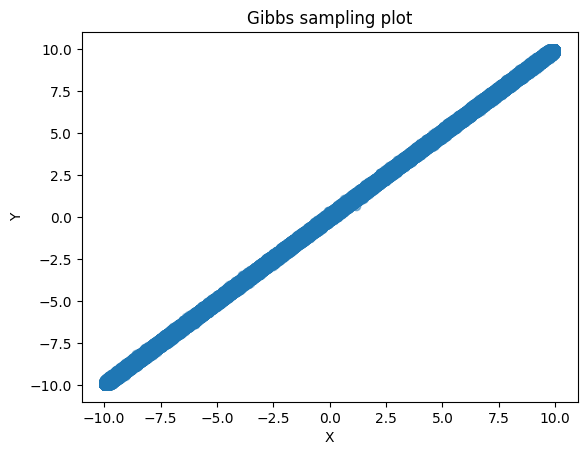

In [101]:
#check the shape of the gibbs samples
X_samples, Y_samples = gibbs_sampler_2(10000000, burn_in=1000, seed=48).T
plt.scatter(X_samples, Y_samples, alpha=0.5)
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Gibbs sampling plot")
plt.show()

Find C using the C=1/400 E(func)

In [ ]:
#1.5
n_steps = 10000000
samples_hast, rejection_rate = metropolis_hastings(n_steps=n_steps, burn_in=1000, sigma2=0.055, seed=43)
expectation_hast = np.mean(np.exp(100 * (samples_hast[:, 0] - samples_hast[:, 1])**2))
print("Hastings expectation: " + str(expectation_hast))


Hastings expectation: 3.338456881464684
Gibbs expectation: 3.942943148294312


In [ ]:
n_steps = 10000000
# list of seeds that work well: 43, 49, 53, 59, 62 holy shit 48 was ahh
# Finding the average of multiple samplings 
# chosen randomly
seeds = [43, 49, 53, 62, 68]
# return 5 samples:
samples_gibbs_1 = gibbs_sampler_2(n_steps, burn_in=10000, sigma=0.0831, seed=seeds[0])
expectation_gibbs_1 = np.mean(np.exp(100 * (samples_gibbs_1[:, 0] - samples_gibbs_1[:, 1])**2))
samples_gibbs_2 = gibbs_sampler_2(n_steps, burn_in=10000, sigma=0.0831, seed=seeds[1])
expectation_gibbs_2 = np.mean(np.exp(100 * (samples_gibbs_2[:, 0] - samples_gibbs_2[:, 1])**2))
samples_gibbs_3 = gibbs_sampler_2(n_steps, burn_in=10000, sigma=0.0831, seed=seeds[2])
expectation_gibbs_3 = np.mean(np.exp(100 * (samples_gibbs_3[:, 0] - samples_gibbs_3[:, 1])**2))
samples_gibbs_4 = gibbs_sampler_2(n_steps, burn_in=10000, sigma=0.0831, seed=seeds[3])
expectation_gibbs_4 = np.mean(np.exp(100 * (samples_gibbs_4[:, 0] - samples_gibbs_4[:, 1])**2))
samples_gibbs_5 = gibbs_sampler_2(n_steps, burn_in=10000, sigma=0.0831, seed=seeds[4])
expectation_gibbs_5 = np.mean(np.exp(100 * (samples_gibbs_5[:, 0] - samples_gibbs_5[:, 1])**2))
expectation_gibbs = np.mean([expectation_gibbs_1, expectation_gibbs_2, expectation_gibbs_3, expectation_gibbs_4, expectation_gibbs_5])
print("Gibbs expectation: " + str(expectation_gibbs))

IndexError: list index out of range